# Blood Cell Classification

The primary objective of this project is to compare various machine learning models for the classification of blood cells, with a focus on implementing and evaluating a Multi-Layer Perceptron (MLP) as part of the solution.

## Introduction
In this project, the goal is to automate the classification of blood cell types for large-scale analysis of experiments in leukemia research. The classification task is critical to understanding how different compounds influence the distribution of various blood cell types. This automation eliminates the need for extensive manual effort, allowing for the analysis of thousands of experiments involving millions of cells.

A considerable amount of preprocessing has already been done. Blood samples were stained using Giemsa and captured with an automated microscope. The images were manually classified by cell type and processed through a segmentation pipeline, which separates cell regions from the background and neighboring cells. The segmentation is stored as a segmentation map (see example images and segmentation maps below). The pipeline used for segmentation is based on Cellpose (https://www.cellpose.org).

Additionally, cell-related features were extracted using FIJI/ImageJ, a popular image analysis software (see https://imagej.net/ij/index.html). These features, such as size, shape, and intensity, were measured as per the guidelines outlined here: https://imagejdocu.list.lu/gui/analyze/set_measurements.

As a result, two datasets have been prepared: bloodcells_train.csv and bloodcells_test.csv. The task now is to build a machine learning model to classify the cells based on the extracted features.


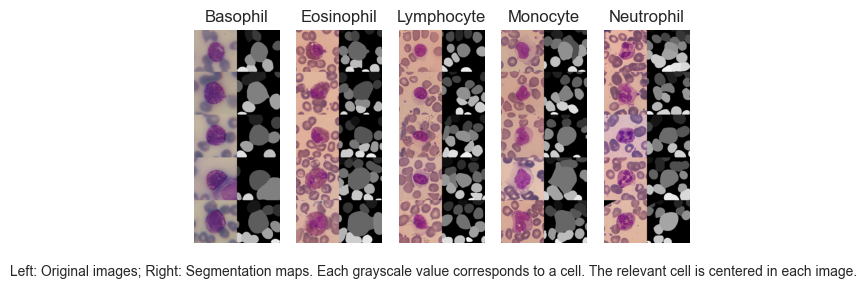

In [4]:
from IPython.display import Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Load images
img1 = PILImage.open('data/Basophil.png')
img2 = PILImage.open('data/Eosinophil.png')
img3 = PILImage.open('data/Lymphocyte.png')
img4 = PILImage.open('data/Monocyte.png')
img5 = PILImage.open('data/Neutrophil.png')

# Subplots
fig, ax = plt.subplots(1,5)

ax[0].imshow(img1)
ax[0].axis('off') 
ax[0].set_title('Basophil') 
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Eosinophil')
ax[2].imshow(img3)
ax[2].axis('off') 
ax[2].set_title('Lymphocyte')
ax[3].imshow(img4)
ax[3].axis('off') 
ax[3].set_title('Monocyte')
ax[4].imshow(img5)
ax[4].axis('off') 
ax[4].set_title('Neutrophil')

# Add a caption to the entire figure
fig.text(0.5, 0.2, 'Left: Original images; Right: Segmentation maps. Each grayscale value corresponds to a cell. The relevant cell is centered in each image.', ha='center', va='bottom')
plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import compose

## 1. Trainings-data

Gain an understanding of the blood cell dataset (/data/bloodcells_train.csv) through visualizations and descriptive statistics to prepare for modeling. Images and segmentation maps are also available for reference (see /data/Images), although they are not required for analysis but may help in understanding the data.

Summarize the findings from the descriptive analysis:
* What insights were gathered? 
* What are the expectations for predicting Class?

Discuss the necessary steps to prepare the dataset for predicting the Class attribute using the available features.

Index(['image filename', 'Area', 'Mean red', 'StdDev red', 'Mode red',
       'Min red', 'Max red', 'Perim.', 'Circ.', 'Feret', 'IntDen',
       'Median red', 'Skew red', 'Kurt red', 'RawIntDen red', 'MinFeret', 'AR',
       'Solidity', 'Mean blue', 'Mean green', 'StDev blue', 'StdDev green',
       'Mode blue', 'Mode green', 'Min blue', 'Min green', 'Max blue',
       'Max green', 'Median blue', 'Median green', 'Skew blue', 'Skew green',
       'Kurt blue', 'Kurt green', 'Class'],
      dtype='object')
(5087, 35)
         image filename   Area  Mean red  StdDev red  Mode red  Min red  \
0  95-5-10-1_231_1.jpg   36063   101.964      49.394        37       20   
1   95-9-4-4_121_1.jpg    6432    97.806      41.106        53       39   
2   95-5-4-1_182_1.jpg   32524   156.996      23.149       157      100   
3   95-8-13-3_60_2.jpg   25293   124.220      47.617        81       54   
4  95-5-10-1_645_2.jpg   44853   167.199      58.149       219       52   

   Max red   Perim.  Circ.   

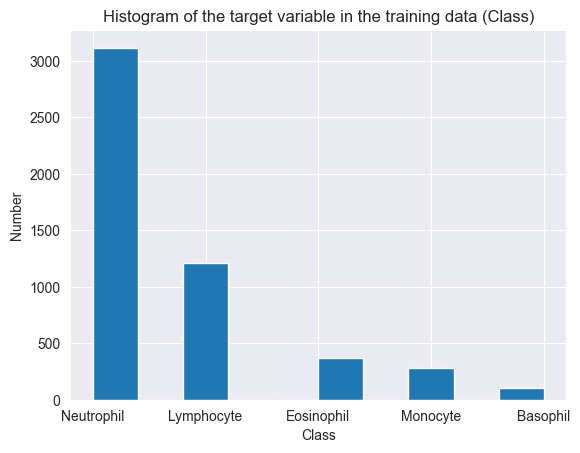

In [6]:
dataset = pd.read_csv("data/bloodcells_train.csv", sep=';')
bc_train = dataset

# Deskriptive statistic
print(bc_train.columns)
print(bc_train.shape)
print(bc_train.head())
print("stats. Train-data:", bc_train.describe())

# Histogram of the target variable (Class)
plt.hist(bc_train['Class'])
plt.xlabel('Class')
plt.ylabel('Number')
plt.title('Histogram of the target variable in the training data (Class)')
plt.show()

5087 observations (blood cells)
Numerical features such as Area, Mean red, StdDev red, etc., have different scales and distributions. The number of neutrophils is significantly higher than the others, followed by lymphocytes, which occur less than half as frequently.
The dataset and classes are generally imbalanced – this should be considered during modeling. (The model could predict neutrophils more accurately but may also be overly influenced by them. Predicting rare classes could be a challenge.)

Further data preparation:
* **Handling missing values:** Check if they exist – possibly impute missing values.
* **Handling imbalanced classes:** Consider upsampling, downsampling, using weighted classes, or appropriate models.
* **Feature engineering:** Check if the existing features are sufficient or if new features need to be created.
Also, consider dimensionality reduction to reduce the number of features and model complexity.
* **Encoding categorical variables:** If categorical variables are present, encode them beforehand.
* **Splitting the data:** Perform a train-test split for validation.
Normalization/Standardization: May be necessary to ensure comparability between features.


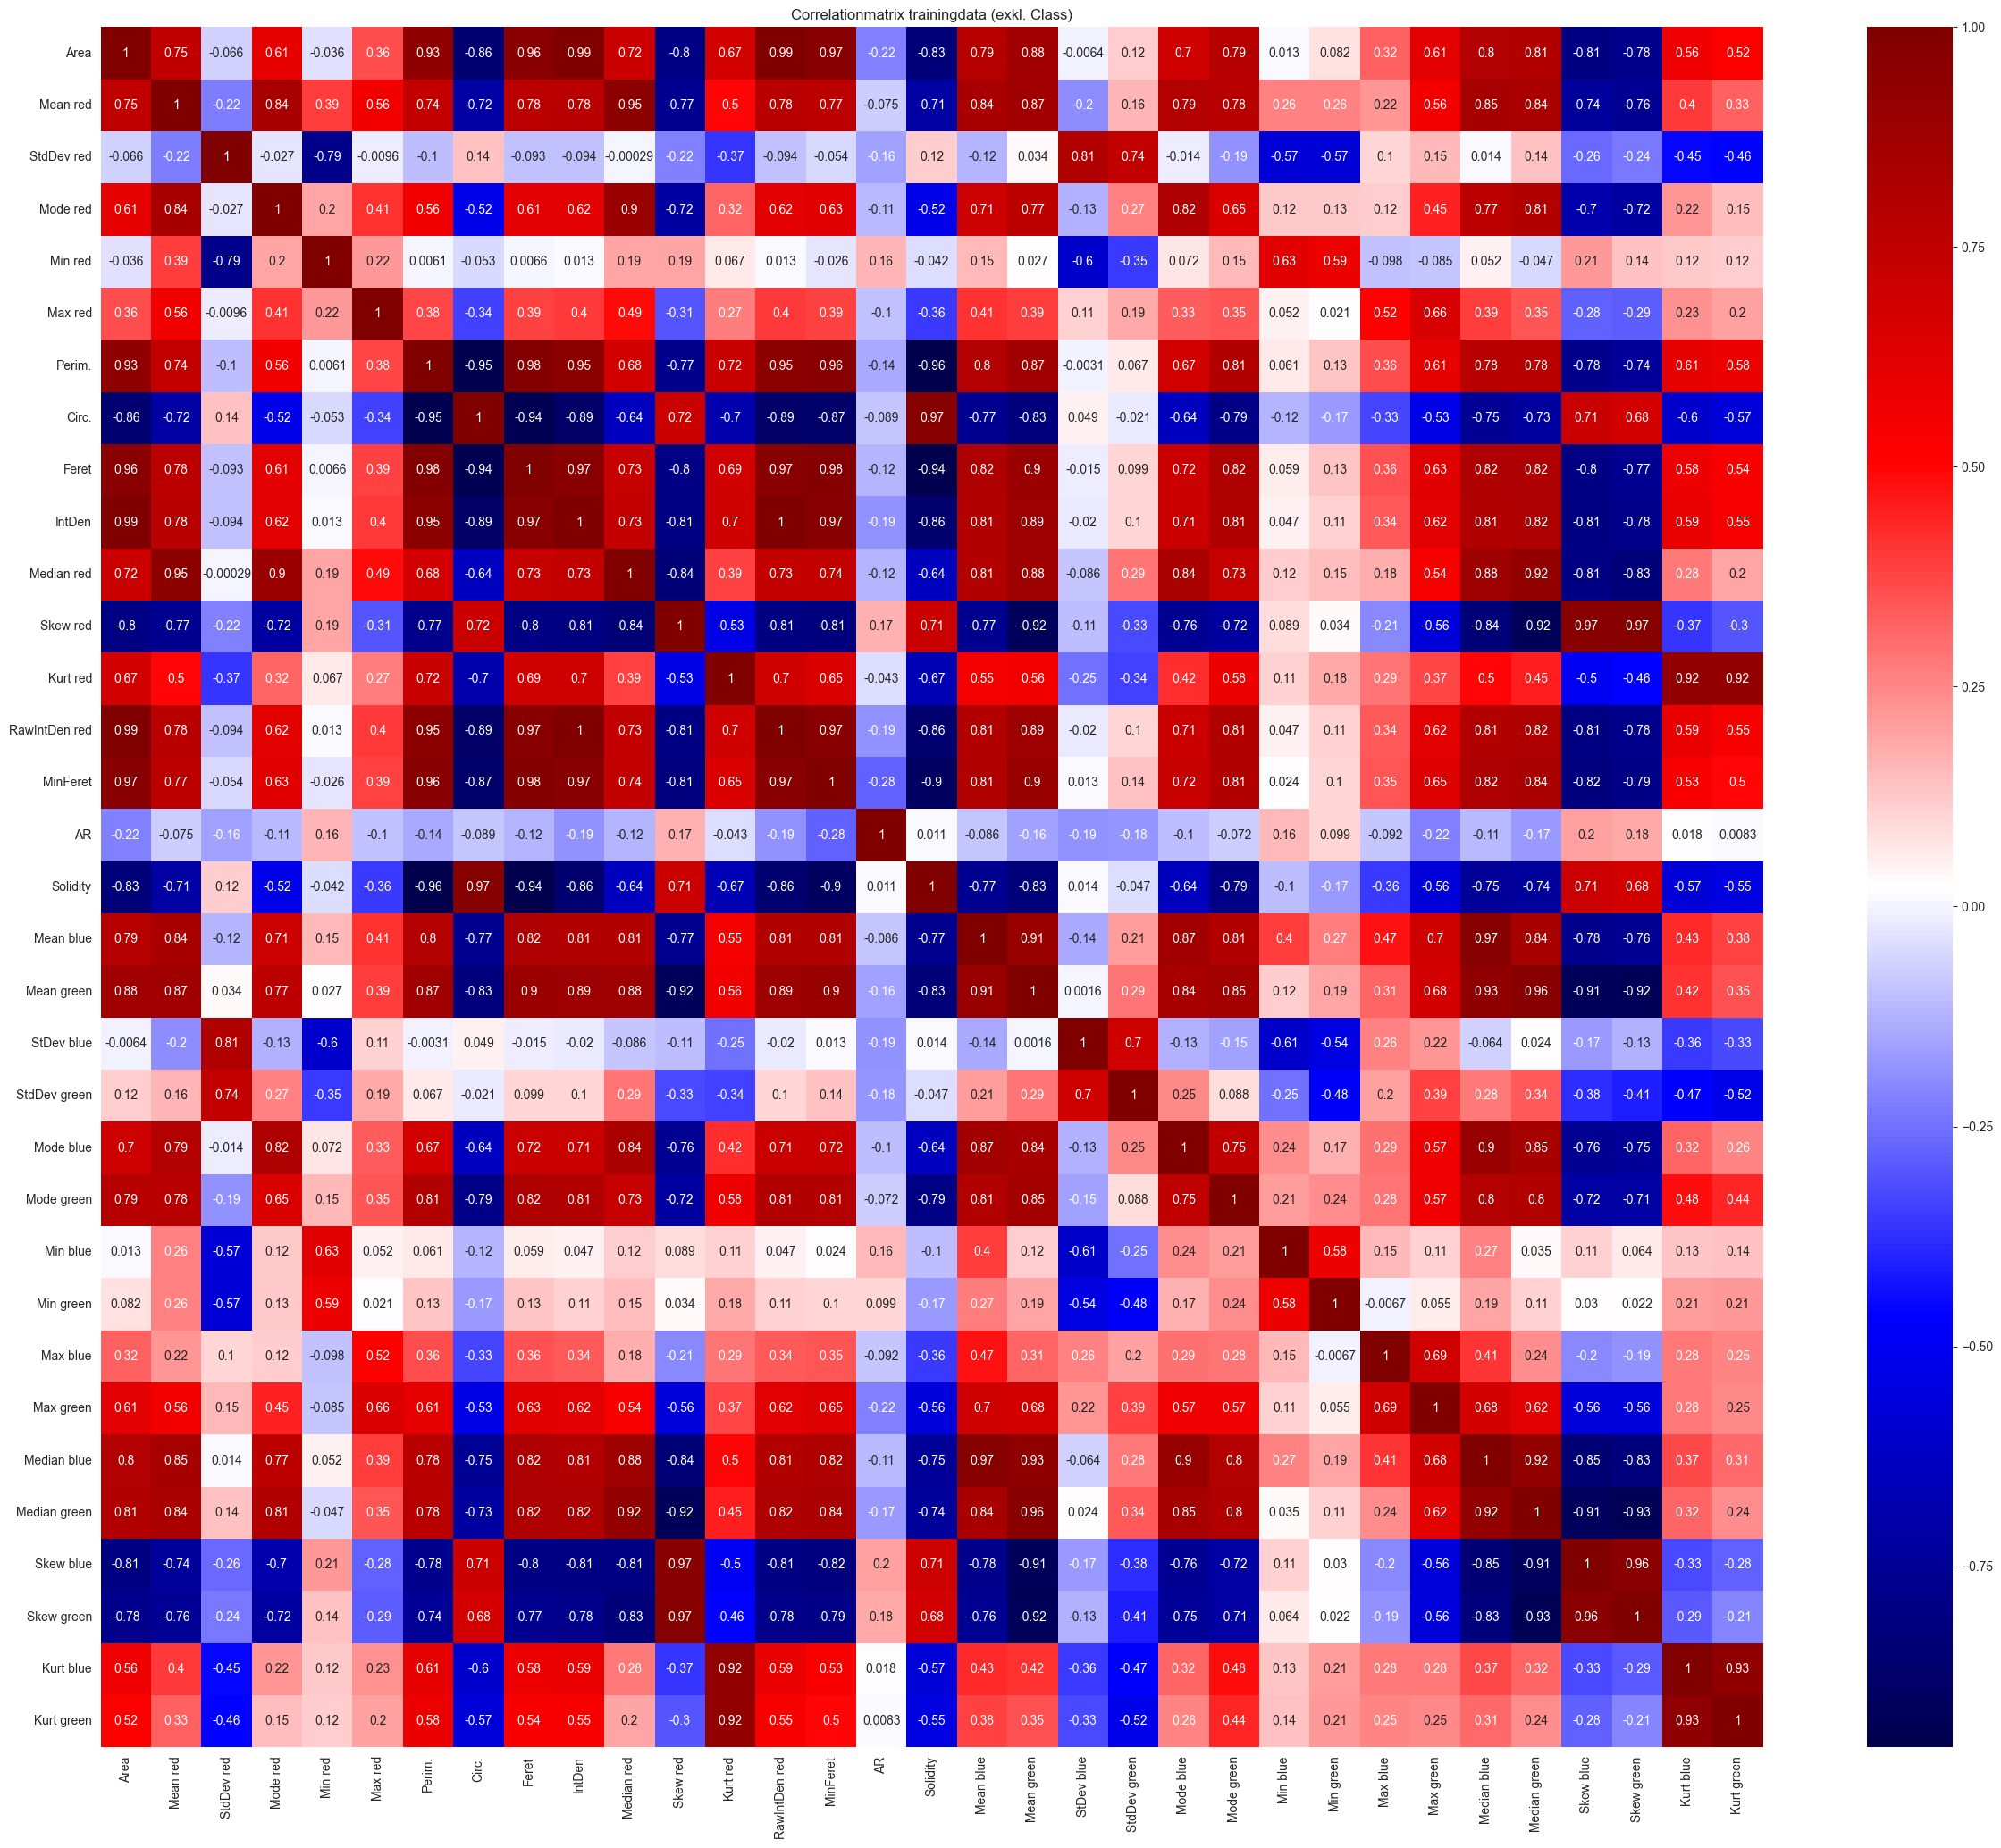

In [7]:
# Correlationmatrix trainingdata
bc_train_corr = bc_train.drop(columns=["image filename", "Class"])
correlation_matrix_train = bc_train_corr.corr()
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix_train, annot=True, cmap='seismic')
plt.title('Correlationmatrix trainingdata (exkl. Class)')
plt.show()

## 2. Testdaten

To evaluate the models, the test dataset (data/bloodcells_test.csv) will be used.

Load the dataset and explore it with visualizations and descriptive statistics. Assess whether the test data is suitable for model evaluation.

Discuss your insights.

Index(['image filename', 'Area', 'Mean red', 'StdDev red', 'Mode red',
       'Min red', 'Max red', 'Perim.', 'Circ.', 'Feret', 'IntDen',
       'Median red', 'Skew red', 'Kurt red', 'RawIntDen red', 'MinFeret', 'AR',
       'Solidity', 'Mean blue', 'Mean green', 'StDev blue', 'StdDev green',
       'Mode blue', 'Mode green', 'Min blue', 'Min green', 'Max blue',
       'Max green', 'Median blue', 'Median green', 'Skew blue', 'Skew green',
       'Kurt blue', 'Kurt green', 'Class'],
      dtype='object')
         image filename    Area  Mean red  StdDev red  Mode red  Min red  \
0   95-5-5-1_144_1.jpg    36006   185.347      18.313       170      143   
1  95-8-10-1_644_2.jpg    20943   109.698      46.423        70       51   
2   95-8-1-1_757_2.jpg   246847   195.656      33.860       210       55   
3  95-8-10-1_496_1.jpg    48803   178.445      34.258       209       91   
4   95-8-3-1_205_1.jpg    20789   112.581      28.582       102       71   

   Max red    Perim.  Circ.    Fer

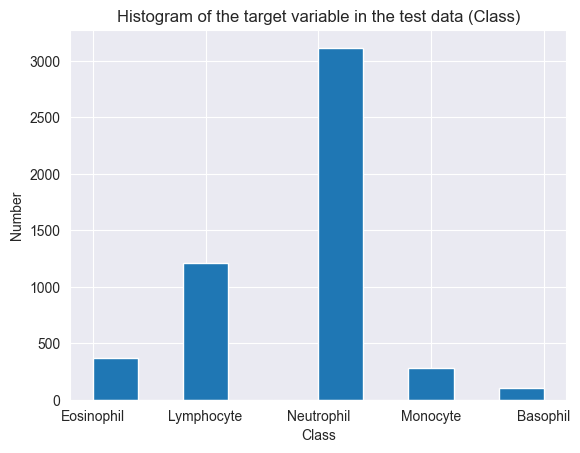

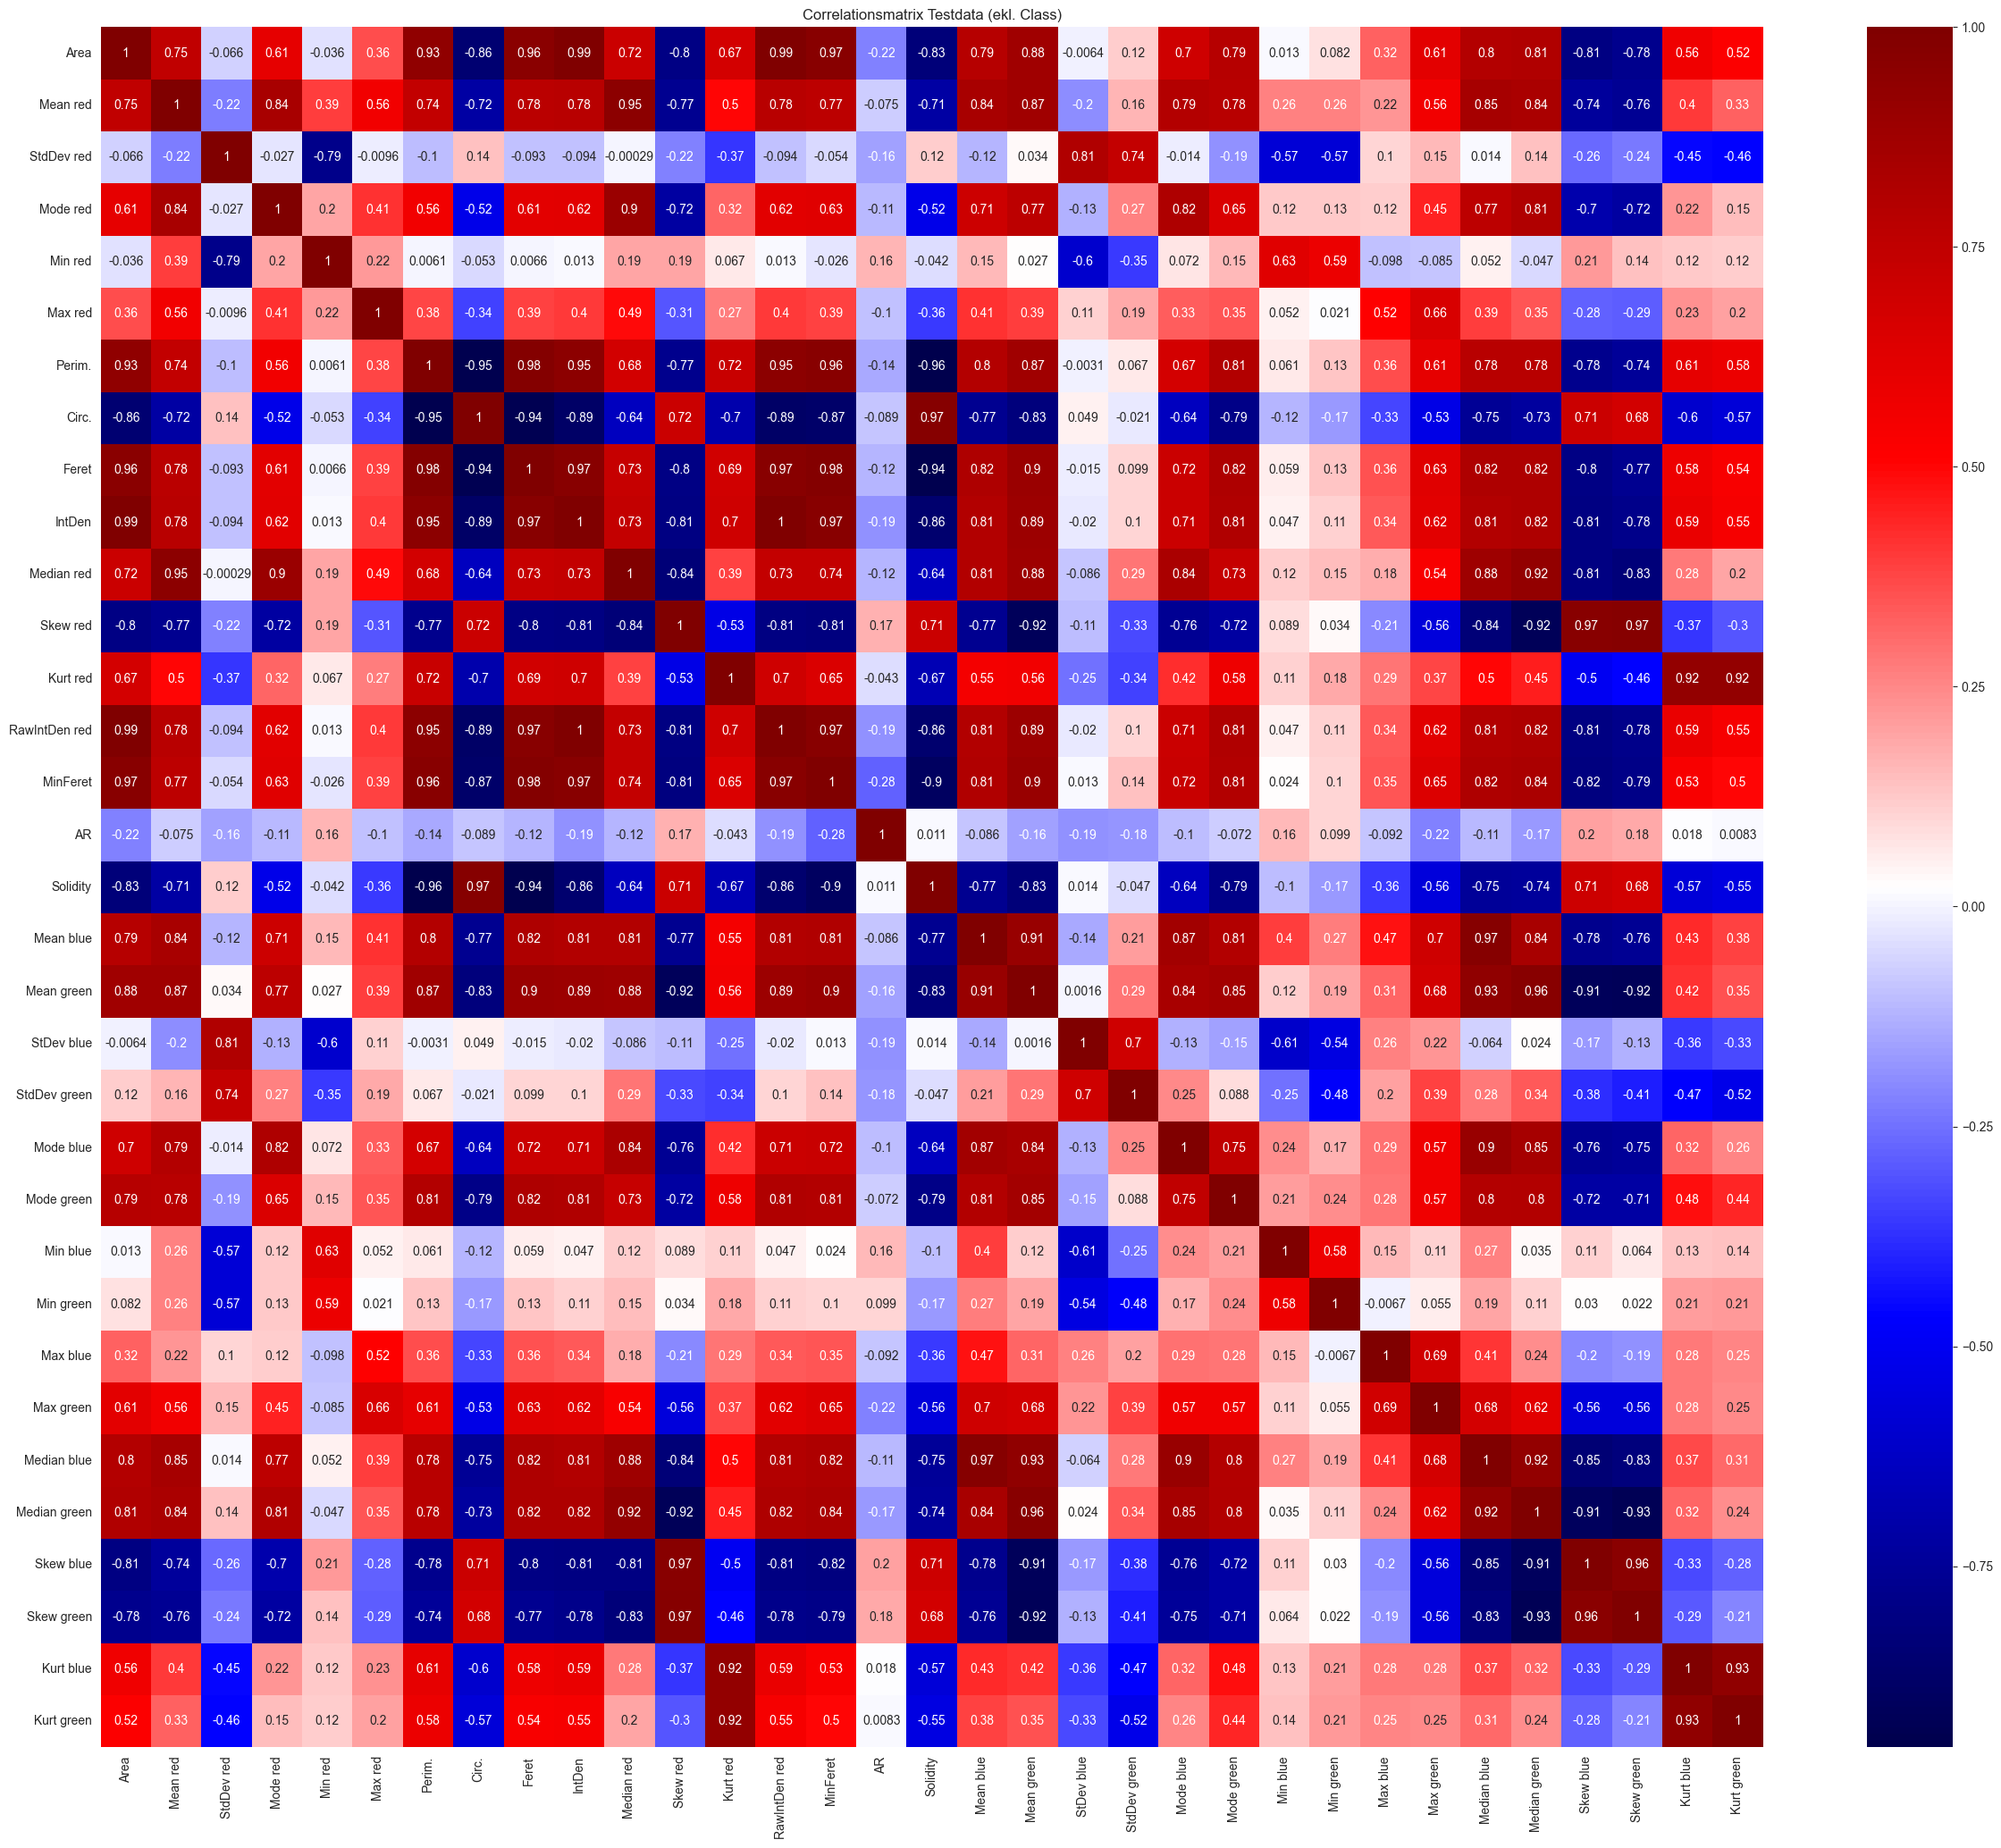

In [9]:
bc_test = pd.read_csv("data/bloodcells_test.csv", sep=';')

print(bc_test.columns)
print(bc_test.head())
print(bc_test.shape)
print("stats testdata:", bc_test.describe())

# Histogram of the target variable (Class)
plt.hist(bc_test['Class'])
plt.xlabel('Class')
plt.ylabel('Number')
plt.title('Histogram of the target variable in the test data (Class)')
plt.show()

# Correlationmatrix Testdata
bc_test_corr = bc_train.drop(columns=["image filename", "Class"])
correlation_matrix_test = bc_test_corr.corr()
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix_test, annot=True, cmap='seismic')
plt.title('Correlationsmatrix Testdata (ekl. Class)')
plt.show()

At first glance, the distribution of the training and test data with respect to the classes appears to be very similar, which is also supported by the statistical metrics. Therefore, the test data seems well-suited for model evaluation, and the issue of handling imbalanced classes may not be necessary.

However, the correlation matrix of the features from both the training and test data shows that there are many highly correlated features, which could potentially lead to problems such as:

* **Multicollinearity:** When two or more predictors are highly correlated. This can make the estimates of the regression coefficients unstable, making the model harder to train and more prone to overfitting.
* **Overfitting:** The model may over-adapt to the training data, possibly learning "noise," random errors, or variations. This makes the model less generalizable to new data.
* **Model complexity:** The model may become overly complex and harder to interpret.
* **Increased computational cost:** The processing time could become too large, making the model inefficient.

Potential solutions:
* **Feature selection:** Identify highly correlated features using the correlation matrix, etc. Remove selected correlated pairs (but be cautious not to remove all).
* **Regularization techniques:** To combat overfitting. Lasso regression (adds a regularization penalty that reduces some coefficients to zero, effectively performing feature selection), PCA (Principal Component Analysis), Random Forest Feature Importances (a classifier from a package that evaluates the importance of features).
* **Dimensionality reduction:** PCA or t-SNE, to reduce dimensions without losing much information.
Additionally, the target class could be encoded and included in the correlation matrix analysis.


In [10]:
# Correlationscoefficient
correlation_coefficient = np.corrcoef(correlation_matrix_train.values.flatten(), correlation_matrix_test.values.flatten())[0, 1]
print("Correlationscoefficient Trainings- und Testcorrelationmatrix:", correlation_coefficient)

Correlationscoefficient Trainings- und Testcorrelationmatrix: 0.9999999999999998


The high value (max. 1.0) of the correlation coefficient between the training and test correlation matrices shows that the correlated pairs in the training and test datasets match, making it unnecessary to differentiate further. Therefore, the test dataset is well-suited for validation.

Since there is no in-depth expertise in the study of blood cell types, the Variance Inflation Factor (VIF) will be used for feature selection. One could use a package for faster execution or manually select features based on the correlation matrices.

In [128]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def variance_inflation_factor(X, feature_index):
    y = X[:, feature_index]
    X = np.delete(X, feature_index, axis=1)
    
    # Add a column of ones to X to account for the intercept
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Calculate R-squared
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    y_pred = X @ beta
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    if r_squared >= 1:
        return np.inf
    else:
        return 1 / (1 - r_squared)
    

vif_data = calculate_vif(bc_train_corr)
print(vif_data)

threshold = 60.0
# Identifizieren der zu entfernenden Merkmale
features_to_remove = vif_data[vif_data["VIF"] > threshold]["Feature"].tolist()

# Anzeigen Spaltennamen mit VIF-Wert über Schwellenwert 60
print("Spalten mit einem VIF-Wert über 60:")
print(features_to_remove)

          Feature         VIF
0            Area  455.793768
1        Mean red  215.627076
2      StdDev red   24.950217
3        Mode red    6.516419
4         Min red   19.909358
5         Max red    6.390143
6          Perim.   70.582942
7           Circ.   91.440508
8           Feret  370.561276
9          IntDen         inf
10     Median red  192.971101
11       Skew red   55.483570
12       Kurt red   17.959354
13  RawIntDen red         inf
14       MinFeret  323.241954
15             AR    7.058173
16       Solidity  138.964251
17      Mean blue  173.961606
18     Mean green  269.876987
19     StDev blue    8.985202
20   StdDev green   12.851272
21      Mode blue    7.694048
22     Mode green    5.635700
23       Min blue    5.595272
24      Min green    5.651868
25       Max blue    4.572610
26      Max green    8.106735
27    Median blue  202.481438
28   Median green  169.019834
29      Skew blue   36.651917
30     Skew green   55.946815
31      Kurt blue   12.553207
32     Kur

A VIF value of "inf" indicates perfect multicollinearity, which could cause issues, and such columns should be removed. A VIF threshold of 10 is typically considered acceptable, while a stricter threshold of 5 can also be used. However, during later testing with logistic regression, it was observed that such strict thresholds had a negative impact on the model's accuracy. Therefore, the threshold was set more generously at a value of 60, which visibly improved the model's performance. All features with a VIF score above this threshold are removed. 

In [129]:
bc_train = bc_train.drop(columns=features_to_remove)
bc_test = bc_test.drop(columns=features_to_remove)
print(bc_train.head())

         image filename  StdDev red  Mode red  Min red  Max red  Skew red  \
0  95-5-10-1_231_1.jpg       49.394        37       20      187    -0.021   
1   95-9-4-4_121_1.jpg       41.106        53       39      190     0.493   
2   95-5-4-1_182_1.jpg       23.149       157      100      251     0.777   
3   95-8-13-3_60_2.jpg       47.617        81       54      217     0.302   
4  95-5-10-1_645_2.jpg       58.149       219       52      239    -0.564   

   Kurt red     AR  StDev blue  StdDev green  ...  Mode green  Min blue  \
0    -1.671  1.220      23.131        49.976  ...           7        74   
1    -1.046  1.730      19.524        35.284  ...          10        79   
2     0.429  1.497      10.270        33.756  ...          53       117   
3    -1.561  1.309      25.461        53.243  ...          11        85   
4    -1.411  1.145      26.920        60.065  ...          10        84   

   Min green  Max blue  Max green  Skew blue  Skew green  Kurt blue  \
0          0   

In [130]:
# Prüfen auf NAs
missing_values_train = bc_train.isnull().sum()
missing_values_test = bc_test.isnull().sum()
print("Anzahl der fehlenden Werte pro Spalte:")
print(missing_values_train, missing_values_test)

# Prüfen auf kategorische Var
categorical_variables_train = bc_train.select_dtypes(include=['object'])
categorical_variables_test = bc_test.select_dtypes(include=['object'])

print("\nKategorische Variablen Train:")
print(categorical_variables_train)
print("\nKategorische Variablen Test:")
print(categorical_variables_test)
print(bc_train['Class'].dtype)
print(bc_test['Class'].dtype)

Anzahl der fehlenden Werte pro Spalte:
image filename    0
StdDev red        0
Mode red          0
Min red           0
Max red           0
Skew red          0
Kurt red          0
AR                0
StDev blue        0
StdDev green      0
Mode blue         0
Mode green        0
Min blue          0
Min green         0
Max blue          0
Max green         0
Skew blue         0
Skew green        0
Kurt blue         0
Kurt green        0
Class             0
dtype: int64 image filename    0
StdDev red        0
Mode red          0
Min red           0
Max red           0
Skew red          0
Kurt red          0
AR                0
StDev blue        0
StdDev green      0
Mode blue         0
Mode green        0
Min blue          0
Min green         0
Max blue          0
Max green         0
Skew blue         0
Skew green        0
Kurt blue         0
Kurt green        0
Class             0
dtype: int64

Kategorische Variablen Train:
            image filename       Class
0     95-5-10-1_231_1.jpg

There are no missing values.
Categorical variables: image filename & Class -> objects.
Furthermore, based on the descriptive statistics (mentioned earlier), it can already be inferred that there are no outliers.

## 3. Modell-Evaluation

Discuss which metrics are appropriate for evaluating the current problem.

* What are their advantages and disadvantages?
* What approaches exist for aggregating metrics across multiple classes? 

## Metrics for Evaluation:

1) Accuracy (Genauigkeit):
    * Advantage: Easy to understand and interpret. Shows how often the model classifies correctly.
    * Disadvantage: Misleading for imbalanced classes. If one class dominates the dataset, it will be predicted well, but rarer classes may not be predicted correctly or poorly.

2) Precision and Recall:
    * Advantage: Precision indicates how many of the positively identified cases are actually positive. Recall shows how many of the actual positive cases were correctly identified.
    * Disadvantage: There is a trade-off between Precision and Recall. High Precision often leads to low Recall, and vice versa.

3) F1 Score:
    * Advantage: Combines Precision and Recall into a single metric, making it suitable for imbalanced classes.
    * Disadvantage: Does not provide insight into how the model handles individual classes.

4) Confusion Matrix:
    * Advantage: Displays model performance for each class and allows a detailed analysis of False Positives and False Negatives.
    * Disadvantage: Can become confusing with many classes.

5) ROC-AUC(Receiver Operating Characteristic Area Under Curve):
    * Advantage: Robust for imbalanced classes and independent of decision thresholds.
    * Disadvantage: Not directly applicable to multi-class classification – requires aggregation across classes, which may lead to loss of information.

Approaches for Aggregating Metrics Across Multiple Classes:

1) Micro and Macro Average:
    * Micro calculates the metric for each class and then averages the result across all instances.
    * Macro calculates the metric for each class separately and then averages the results.
    
2) Weighted Average:
    * The metric for each class is weighted according to its frequency. Useful when dealing with imbalanced class distributions.

3) OvA bzw OvO (OnevsAll bzw OnevsOne):
    * For binary classifiers, these methods evaluate each class separately, and then metrics are aggregated.
    
General Consideration:
The choice of metrics depends on the application and objectives. For example, in medical settings, where False Negatives are critical, Recall is often more important. However, in many cases, Accuracy is sufficient.

In this project: Accuracy, F1 Score, and Weighted Average (ideal for class imbalance) will be used.

## 4. 'Dummy-classifier'

We want to evaluate two heuristic classification strategies as a baseline:

1. A dummy classifier that always predicts the most frequent label from the training data.
2. A dummy classifier that predicts a random label, with each label having the probability of its occurrence in the training data.
Calculate the overall accuracy and the unweighted average F1-score on the test data for both strategies.

Discuss the results and the insights gained for the subsequent model-based approaches.

In [166]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Ungewichteter mittlerer F1 Score (Prec & Recall)
def f1_score(y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    classes = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))
    f1_scores = []
    for c in classes:
        tp = np.sum((y_true == c) & (y_pred == c))
        tn = np.sum((y_true != c) & (y_pred != c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    return np.mean(f1_scores)

# Bestimme die Wahrscheinlichkeiten der Klassen im Trainingsdatensatz
class_probabilities = bc_train['Class'].value_counts(normalize=True)
class_labels = class_probabilities.index
class_probabilities = class_probabilities.values

# Ausgabe der Klassennamen und ihrer Wahrscheinlichkeiten
for label, prob in zip(class_labels, class_probabilities):
    print(f"Class: {label}, Prob.: {prob}")

# Definiere Features X und Labels y für Trainings- und Testdaten
X_train = bc_train.drop(columns=['Class'])  # Features train ohne class da diese ja zielvar ist
y_train = bc_train['Class']                 # Lables train nur Class
X_test = bc_test.drop(columns=['Class'])
y_test = bc_test['Class']

# Dummy-Klassifikator für häufigstes Label
pred_most_frequent = pd.Series(y_train.mode()[0], index=y_test.index)
accuracy_most_frequent = accuracy(y_test, pred_most_frequent)
f1_most_frequent = f1_score(y_test, pred_most_frequent)

print("\nDummy-Klassifikator häufigstes Label:")
print("Accuracy:", accuracy_most_frequent)
print("F1-Score:", f1_most_frequent)

# Bestimme die Wahrscheinlichkeiten der Klassen im Trainingsdatensatz
class_probabilities = bc_train['Class'].value_counts(normalize=True)

# Dummy-Klassifikator für zufälliges Label
random_class = np.random.choice(class_probabilities.index, p=class_probabilities.values)
pred_random = pd.Series(np.random.choice(y_train.unique(), size=len(y_test), p=class_probabilities.values), index=y_test.index)
accuracy_random = accuracy(y_test, pred_random)
f1_random = f1_score(y_test, pred_random)

print("Dummy-Klassifikator zufälliges Label:")
print("Accuracy:", accuracy_random)
print("F1-Score:", f1_random)
print("Wahrscheinlichkeit der zufälligen Klasse:")
print(random_class, class_probabilities[random_class])

Class: Neutrophil, Prob.: 0.6123451936308236
Class: Lymphocyte, Prob.: 0.23845095341065461
Class: Eosinophil, Prob.: 0.07312758010615295
Class: Monocyte, Prob.: 0.05523884411244348
Class: Basophil, Prob.: 0.0208374287399253

Dummy-Klassifikator häufigstes Label:
Accuracy: 0.6124213836477987
F1-Score: 0.15192588980984884
Dummy-Klassifikator zufälliges Label:
Accuracy: 0.43415880503144655
F1-Score: 0.1972991306805802
Wahrscheinlichkeit der zufälligen Klasse:
Neutrophil 0.6123451936308236


Most Frequent Label:

Accuracy: 61%
F1 Score: 15%
The model always predicts the class "Neutrophil" because it is the dominant, most frequent class. Therefore, the accuracy is approximately as high as the probability/percentage of this class in the dataset. The low F1 score shows that the model struggles to recognize other classes (due to imbalanced classes). The dominant class leads to bias, and no relationships between the features and the target variable are considered.

Random Label:

Accuracy: ~45% (varies depending on the randomly chosen class)
F1 Score: 20%
In this case, the model also struggles to predict rare classes, but the F1 score is slightly better (though still poor) due to a more balanced distribution of True Positives, False Positives, etc. This indicates a somewhat more balanced trade-off between Precision and Recall.

The key takeaway is that the modeling approach must account for the imbalanced class distribution, and it is crucial to use the appropriate evaluation metrics.

## 5. Logistic Regression

As a baseline model for predicting blood cell types, logistic regression will be used.

Implement a simple, properly regularized, purely linear logistic regression approach. Optimize for the F1-score using scikit-learn.

Evaluate the model on the test dataset in terms of overall accuracy and the unweighted average F1-score, and plot the confusion matrix.

Discuss the results.

Overall Accuracy: 0.9058569182389937
Ungewichteter mittlerer F1-Score: 0.8081940352887813
Gewichteter mittlerer F1-Score: 0.9020357630547768


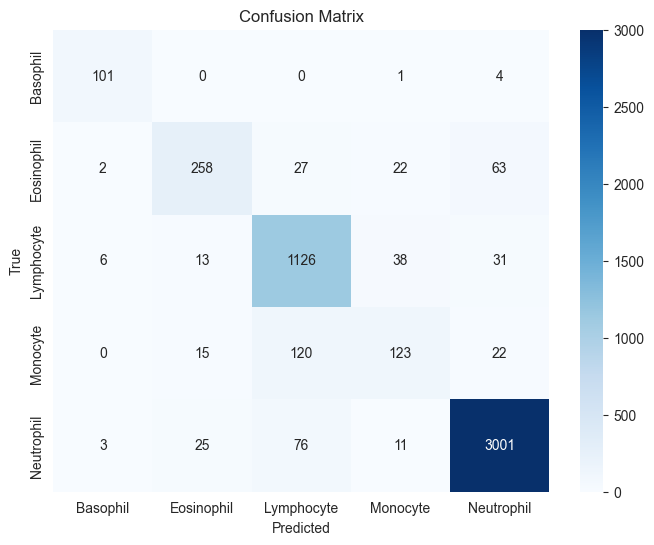

Anzahl der Neutrophils in Trainingsdaten: 3115


In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Entfernen nicht-numerischer Spalten und splitten in Train und Testdata
X_train = bc_train.drop(columns=['Class']).select_dtypes(include=['float64', 'int64'])
X_test = bc_test.drop(columns=['Class']).select_dtypes(include=['float64', 'int64'])
y_train = bc_train['Class']
y_test = bc_test['Class']

# Standardisieren (wichtig bei logistischer Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LogisticRegression aus Sklearn beinhaltet default mässig die L2-Regularisierung (Ridge) mit penalty 12.
# Initialisiere logistischen Regressionsklassifikator & fitten
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_scaled, y_train)

# Predicte auf Testdaten
y_pred = logreg.predict(X_test_scaled)

# Berechne Scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro') #ungewichtet
f1_weig = f1_score(y_test, y_pred, average='weighted')#gewichtet
conf_matrix = confusion_matrix(y_test, y_pred)

print("Overall Accuracy:", accuracy)
print("Ungewichteter mittlerer F1-Score:", f1)
print("Gewichteter mittlerer F1-Score:", f1_weig)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

neutrophil_count_train = (bc_train['Class'] == 'Neutrophil').sum()
print("Anzahl der Neutrophils in Trainingsdaten:", neutrophil_count_train)


High accuracy and F1 score indicate that the model converges and performs well. The F1 score also suggests a good balance between precision and recall, which is reflected in the confusion matrix. As expected, logistic regression works particularly well in handling class imbalances.

From the confusion matrix, it is clear that the most frequent class, Neutrophil, was predicted correctly in 3028 out of 3115 cases, meaning that it is predicted the best, as anticipated. The more frequent a class is, the better it can be predicted.

* **True Positive:** The positive class is predicted correctly.
* **True Negative:** The negative class is predicted correctly, or the absence of the class is correctly predicted when it is not present.
* **False Positive:** The positive class is incorrectly predicted, meaning the class is predicted even though it is not present (false alarm).
* **False Negative:** The negative class is incorrectly predicted, meaning the absence of the class is predicted even though it is actually present (missed detection).

The Y-axis represents the actual classes.
The X-axis represents the predicted values.
The correct predictions, or true positives, are located on the main diagonal (from top left to bottom right).


## 6. Multi-Layer Perceptron

Implement a Multi-Layer Perceptron with Sigmoid activation functions for multi-class classification.

The architecture (number of layers/units per layer), regularization($\alpha$), learning rate ($\eta$), and batch size should all be configurable.

Initialize the weights randomly with small values, for example, from the interval $[-0.7, 0.7]$.  Make sure the model fitting is reproducible by setting random seeds for weight initialization.

Extend the provided class for the implementation.

#### Cost Function

The following cost function $J$ should be minimized (cross-entropy with regularization):

\begin{align}
J(\mathbf{w}) &= \frac{1}{N}\sum_{i=1}^{N} \sum_{k=1}^{K} \Big(- y_k^{(i)} \log \hat{y}_k^{(i)} \Big) + C \\
C &= \frac{\alpha}{2} \sum_{l=1}^{L}\sum_{j=1}^{u^{(l)}} \sum_{i=1}^{u^{(l-1)}} (w^{(l)}_{ij})^2
\end{align}

#### Notation

- $N$: Number of data points
- $L$: Number of layers (excluding the input layer)
- $K$: Number of classes
- $p$: Number of input features
- $\alpha$: Regularization factor
- $\mathbf{a}^{(l)}$ Activations in layer $l$ (l=0 is Input-Layer)
- $\mathbf{z}^{(l)}$ pre-activations / logits in layer $l$

- $\mathbf{y}^{(i)} \in \{0, 1\}$: One-hot encoded Vektor vector with dimension $\mathbb{R}^K$, with 1 indicating the class label
- $\hat{y}_k^{(i)}$ Prediction for class $k$, $P(Y=k| x^{(i)})$ 
- $w^{(l)}_{ij}$: Weight/parameter $ij$ from layer $l$
- $W^{(l)}$ Parameters from layer $l$ mit $\in \mathbb{R}^{u^{(l-1)} \times u^{(l)}}$ or with bias in $\mathbb{R}^{(u^{(l-1)}+1) \times u^{(l)}}$
- $u^{(l)}$: Number of nodes (units) in layer $l$ excluding bias node
- $g()$: Activation function


#### Forward Pass

For a given data point $\mathbf{x}^{(i)}$. , assuming the bias has been added as a column of ones $x_0^{(i)}=1$.

\begin{align*}
\mathbf{a}^{(0)} &= \mathbf{x}^{(i)} \\
\mathbf{z}^{(1)} &= \mathbf{a}^{(0)T}W^{(1)} \\
\mathbf{a}^{(1)} &= g(\mathbf{z}^{(1)}) \\
.. &= .. \\
\mathbf{z}^{(l)} &= \mathbf{a}^{(l-1)T}W^{(l)} \\
\mathbf{a}^{(l)} &= g(\mathbf{z}^{(l)}) \\
.. &= .. \\
\mathbf{\hat{y}}_k^{(i)} &= a_k^{(L)} \\
g(\mathbf{z}^{(l)}) &=  \frac{1}{1+e^{-z^{(l)}}} & \text{Sigmoid activation for hidden-Layers } (l \lt L)  \\
a_i^{(L)} &= \sigma(\mathbf{z}^{(L)})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} & \text{ Softmax-Function for } l = L
\end{align*}

#### Backpropagation

Backpropagation is the core algorithm used to train neural networks by computing the partial derivatives of the loss function with respect to the parameters. The gradient of the loss function is propagated back through the network using the chain rule. This algorithm should be used to compute all $\frac{\partial J}{\partial \mathbf{w_{ij}^{(l)}}}$. The following relationships may be useful in the implementation:


\begin{align*}
\frac{\partial a^{(l)}}{\partial z^{(l)}} &= g(z^{(l)})(1 - g(z^{(l)})) = a^{(l)} \odot (1- a^{(l)}) & \text{for } l \lt L\\
\frac{\partial z^{(l)}}{\partial a^{(l-1)}} &= W^{(l)} \\
\frac{\partial z^{(l)}}{\partial W^{(l)}} &= a_i^{(l-1)}
\end{align*}


The gradient of the cost function with respect to the weights $W$ can be computed recursively:

\begin{align*}
\frac{\partial J}{\partial \mathbf{z}^{(L)}} &= \delta^{(L)} = \mathbf{\hat{y}} - \mathbf{y} & \text{initialize backprop here. }\\
\delta^{(l)} &= \Big(\frac{\partial z^{(l+1)}}{\partial a^{(l)}} \delta^{(l+1)} \Big) \odot \frac{\partial a^{(l)}}{\partial z^{(l)}} & \text{compute backpropagation steps iteratively for } l \lt L \\
\frac{\partial J}{\partial W^{(l)}} &=  \Big(\frac{\partial z^{(l)}}{\partial W^{(l)}}\Big)^T \delta^{(l)}  & \text{these are the weight gradients!}
\end{align*}


#### Vectorization

The forward pass and backpropagation can be computed efficiently by vectorizing the operations. Activation values are computed for all data points$N$. simultaneously. Bias vectors $\mathbf{b}$ are directly added to the activation matrices. Backpropagation can also be vectorized by computing the average gradient over all data points. Without vectorization, the implementation will be too slow. Here’s an outline for the forward propagation:


\begin{align*}
\mathbf{X} & \in \mathbb{R}^{N \times (p + 1)} \\
\mathbf{A}^{(l)} & \in \mathbb{R}^{N \times (u^{(l)} + 1)} \\
\mathbf{Z}^{(l)} & \in \mathbb{R}^{N \times (u^{(l)})} \\
\mathbf{W}^{(l)} & \in \mathbb{R}^{(u^{(l-1)} + 1) \times u^{(l)}} \\
\mathbf{b}^{(l)} & \in \mathbb{R}^{u^{(l)} \times 1} \\
\mathbf{Z}^{(1)} &= \mathbf{X} \mathbf{W}^{(1)} \\
\mathbf{A}^{(1)} &= g( \mathbf{Z}^{(1)}) & \text{add bias node if necessary}\\
... \hspace{4pt} &= \hspace{4pt} ... \\
\mathbf{A}^{(L)} &= g( \mathbf{Z}^{(L)}) & \text{no bias at output}\\
\end{align*}


In [200]:
import copy
from itertools import islice
from typing import List, Tuple, Union, Iterable

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder


class MLPClassifier(BaseEstimator):
    def __init__(
            self,
            num_nodes_per_layer: List[int],
            lr: float = 0.01,
            alpha: float = 0.0,
            batch_size: Union[int, None] = None,
            max_num_steps: int = 1000,
            weights_init_range: Tuple[float, float] = (-.7, .7),
            adaptive_lr_constant: float = 0.0,
            min_lr: float = 1e-4,
            random_seed: int = 123
    ):
        self.num_nodes_per_layer = num_nodes_per_layer
        self.lr = lr
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_num_steps = max_num_steps
        self.weights_init_range = weights_init_range
        self.adaptive_lr_constant = adaptive_lr_constant
        self.min_lr = min_lr
        self.random_seed = random_seed
        self.weights_ = []
        self.costs_ = []
        self._initialize_weights()
        self.epoch_weights = []

    #@staticmethod
    #def num_nodes_per_layer(X_train, y_train):
    #    num_features = X_train.shape[1]
    #    num_classes = y_train.shape[1]
    #    return [num_features] + [30, 15] + [num_classes]

    def _initialize_weights(self):
        np.random.seed(self.random_seed)
        self.weights_ = []
        for i in range(len(self.num_nodes_per_layer) - 1):
            input = self.num_nodes_per_layer[i] + 1  
            output = self.num_nodes_per_layer[i + 1]
            w = np.random.uniform(self.weights_init_range[0], self.weights_init_range[1], (input, output))
            self.weights_.append(w)

    def forward(self, X: np.ndarray) -> List[np.ndarray]:
        activations = [X]
        for i in range(len(self.weights_)):
            Z = np.hstack([np.ones((activations[-1].shape[0], 1)), activations[-1]])
            A = np.dot(Z, self.weights_[i])
            if i == len(self.weights_) - 1:
                A = self.softmax(A)
            else:
                A = self.sigmoid(A)
            activations.append(A)
        return activations

    def backward(self, activations: List[np.ndarray], delta_upstream: np.ndarray) -> List[np.ndarray]:
        gradients = []
        delta = delta_upstream
        for i in range(len(self.weights_)-1, -1, -1):
            Z = np.hstack([np.ones((activations[i].shape[0], 1)), activations[i]])
            grad = np.dot(Z.T, delta) / Z.shape[0]
            gradients.insert(0, grad)
            if i != 0:
                delta = np.dot(delta, self.weights_[i][1:].T) * (activations[i] * (1 - activations[i]))
        return gradients

    def fit(
            self,
            X: np.ndarray, y: np.ndarray,
            X_val: Union[np.ndarray, None]=None,
            y_val: Union[np.ndarray, None]=None,
            validate_after_every_num_steps: int=20) -> None:

        lb = LabelBinarizer()
        y = lb.fit_transform(y)
        y_val = lb.transform(y_val) if y_val is not None else None
        
        costs = []
        epoch_weights = []

        for step in tqdm(range(self.max_num_steps)):
            current_lr = max(self.lr * np.exp(-self.adaptive_lr_constant * step), self.min_lr)
            batch_generator = self.generate_batches(X, y, self.batch_size)
            X_batch, y_batch = next(batch_generator)
            activations = self.forward(X_batch)
            y_pred = activations[-1]
            cost = self.calculate_cost(y_batch, y_pred)
            delta_upstream = self.calculate_gradient_of_cost_function(y_batch, y_pred)
            grads = self.backward(activations, delta_upstream)
            for i in range(len(self.weights_)):
                self.weights_[i] -= current_lr * grads[i]

            if X_val is not None and step % validate_after_every_num_steps == 0:
                val_activations = self.forward(X_val)
                val_y_pred = val_activations[-1]
                val_cost = self.calculate_cost(y_val, val_y_pred)
                print(f"Step {step}, Training Cost: {cost:.4f}, Validation Cost: {val_cost:.4f}")
            
            # Kosten zur Liste hinzufügen
            costs.append(cost)
            self.epoch_weights.append(copy.deepcopy(self.weights_))
                
        return costs

    def calculate_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        n_samples = y_true.shape[0]
        logp = - np.sum(y_true * np.log(y_pred))
        cost = logp / n_samples
        return cost

    def calculate_gradient_of_cost_function(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return y_pred - y_true

    def softmax(self, x: np.ndarray) -> np.ndarray:
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.forward(X)[-1]

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy
    
    def generate_batches(
            self, X: np.ndarray, y: np.ndarray,
            batch_size: Union[int, None],
            shuffle: bool = True) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        if not batch_size:
            batch_size = X.shape[0]
            while True:
                yield X, y

        while True:
            shuffled_indices = np.arange(X.shape[0])
            if shuffle:
                np.random.shuffle(shuffled_indices)
            iter_indices = np.arange(X.shape[0])
            slices = islice(iter_indices, 0, None, batch_size)
            for start_index in slices:
                indices_to_select = shuffled_indices[start_index: start_index + batch_size]
                yield X[indices_to_select, :], y[indices_to_select, :]

    def grad_check(
            self, X: np.ndarray, y: np.ndarray,
            epsilon: float=0.0001,
            decimal: int=3,
            verbose: bool=False) -> None:
        """Compare the gradient with finite differences around current point in parameter space
            Args:
                X, y: Data
                epsilon: step to take around current parameters
                decimal: verify equality if approximaton is within +- 1e-<decimal>
        """
        # calculate gradient
        activations = self.forward(X)
        y_hat = activations[-1]
        delta_upstream = self.calculate_gradient_of_cost_function(y, y_hat)
        gradients = self.backward(activations, delta_upstream)
        
        # approximate gradient
        gradients_approx = copy.deepcopy(gradients)
        original_layers = copy.deepcopy(self.weights_)
        
        # Iterate over each parameter of the network
        for i, weights in enumerate(self.weights_):
            for j, _ in enumerate(weights.flat):
                
                # generate copy of original parameters for modification
                modified_layers = copy.deepcopy(original_layers)
                # assign modified layers for use in other methods
                self.weights_ = modified_layers
                # J(theta + epsilon)
                modified_layers[i].flat[j] += epsilon
                y_hat = self.predict_proba(X)
                cost_plus_epsilon = self.calculate_cost(y, y_hat)
                # J(theta - epsilon)
                modified_layers[i].flat[j] -= 2 * epsilon           
                y_hat = self.predict_proba(X)
                cost_minus_epsilon = self.calculate_cost(y, y_hat)
                # Approx gradient with:
                # (J(theta + epsilon) - J(theta - epsilon)) / (2 * epsilon)
                grad_approx = (
                    (cost_plus_epsilon - cost_minus_epsilon) / 
                    (2 * epsilon))
                gradients_approx[i].flat[j] = grad_approx
        # reset layers attribute
        self.weights_ = copy.deepcopy(original_layers)
        
        # normalize gradients
        gradients_approx = [x / np.linalg.norm(x) for x in gradients_approx]
        gradients = [x / np.linalg.norm(x) for x in gradients]
                

        if verbose:
            print('approx : ', gradients_approx)
            print('calc : ', gradients )
        
        for approx, calculated in zip(gradients_approx, gradients):
            np.testing.assert_array_almost_equal(approx, calculated, decimal=decimal)
        print(f"Gradients within +- 1e-{decimal} of approximated gradient!")
        
    def update_weights(self, gradients: List[np.ndarray]):
        """ Update model weights using calculated gradients """
        for i in range(len(self.weights_)):
            self.weights_[i] -= self.lr * gradients[i]


Demonstrate that your implementation works by using the small development dataset (dev_data.csv) to predict the output variable  $y \in \{0, 1, 2\}$ based on the input variables $\mathbf{x} = \left(x_1, x_2\right)$. 
Create a network with 2 hidden layers, each with 20 units/nodes plus a bias unit, and optimize the model coefficients.

Plot the following:
* The development of the cost function throughout the Gradient Descent process.
* The evolution of the decision regions using mlxtend.plotting.plot_decision_regions during training as an animation.
* The confusion matrix.
* Also, calculate the overall accuracy on the development dataset.

Discuss your insights.

In [201]:
# Testphase:
dev_data = pd.read_csv("data/dev_data.csv")

print(dev_data.head())
# Datenvorbereitung
X = dev_data[['x1', 'x2']].values
y = dev_data['y'].values

# Daten skalieren
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Xdev_scaled = (X - X_mean) / X_std

# One-Hot-Encoding der Zielvariable
encoder = OneHotEncoder(sparse_output=False)
ydev_scaled = encoder.fit_transform(y.reshape(-1, 1))

print("Xdev_scal:", Xdev_scaled)
print("ydev_scal:", ydev_scaled)


# Erzeuge und trainiere das Netzwerk
mlperc = MLPClassifier(num_nodes_per_layer=[2, 20, 20, 3], lr=0.1, alpha=0.1, batch_size=None, max_num_steps=2000)
costs = mlperc.fit(Xdev_scaled, ydev_scaled)  # Kostenliste speichern

# Gradientenprüfung
mlperc.grad_check(Xdev_scaled, ydev_scaled, verbose=True)

# Anpassen des Modells an die Trainingsdaten
mlperc.fit(Xdev_scaled, ydev_scaled)

     y        x1        x2
0  1.0 -0.095203  0.278684
1  2.0  3.588686 -0.666809
2  0.0 -2.573853 -1.605410
3  0.0 -2.820451 -1.861976
4  1.0  0.029643  2.958625
Xdev_scal: [[-0.42518191  0.39792358]
 [ 1.10584518 -0.179534  ]
 [-1.45531134 -0.75278208]
 [-1.55779733 -0.90947916]
 [-0.37329603  2.03469199]
 [ 1.2370174  -0.26088746]
 [-0.01614942  0.93683811]
 [ 0.75086752 -0.42603558]
 [-1.12279656 -0.02116913]
 [-0.38823695  0.10149973]
 [ 1.27320934  1.05900576]
 [-0.7957322   0.26393018]
 [-0.89986072  0.30348511]
 [ 0.2021975   2.05834015]
 [ 0.80978181 -0.45131439]
 [-1.44279167  1.17104526]
 [ 0.30531384  0.4683756 ]
 [ 0.52899805  0.64809404]
 [-0.70670212  0.68261495]
 [-0.4881925   0.26973057]
 [ 1.34248138 -1.41077417]
 [-2.2192005  -0.91857499]
 [-1.43527911 -0.116697  ]
 [-0.23244098 -0.22501602]
 [ 0.98744148 -0.8448978 ]
 [-1.11516218  0.01480701]
 [ 1.04429334 -0.94333221]
 [-0.15223937 -1.79213327]
 [-0.22896733 -0.45552253]
 [ 1.02356487  2.52100642]
 [-1.32135555 -0.

  0%|          | 0/2000 [00:00<?, ?it/s]

approx :  [array([[-0.02934548, -0.02922494,  0.00173703, -0.05099776, -0.04648198,
         0.02122211,  0.04218785,  0.03496877, -0.23284004, -0.01860663,
        -0.01068204, -0.08904175,  0.02717143, -0.00321198, -0.01567597,
        -0.00702037,  0.01158851,  0.07389274, -0.13436514,  0.01239279],
       [-0.11861307, -0.13675509, -0.06470269, -0.27303775, -0.140846  ,
         0.15691596,  0.11973391,  0.14614646,  0.57841804, -0.03969909,
         0.05151513, -0.02938948,  0.18257056, -0.03174701, -0.19644991,
         0.14279638, -0.07219547, -0.19928959, -0.13457464, -0.08341442],
       [-0.08761662, -0.0936546 ,  0.0319115 , -0.20490164, -0.08083955,
         0.0571369 ,  0.06411186,  0.06889538,  0.19622647, -0.00420886,
        -0.02241847, -0.13571507,  0.06528915,  0.07149574, -0.10311526,
         0.12008499, -0.00735756, -0.08093772, -0.17048659, -0.04822664]]), array([[-8.21546443e-03,  9.89209479e-03,  3.50591875e-02,
         3.12656280e-02,  1.20358373e-02,  5.8727

  0%|          | 0/2000 [00:00<?, ?it/s]

[0.39859169866976935,
 0.39850346793899444,
 0.39841516378564285,
 0.3983267860944275,
 0.39823833474998516,
 0.39814980963687674,
 0.3980612106395881,
 0.3979725376425306,
 0.3978837905300414,
 0.39779496918638413,
 0.39770607349574977,
 0.3976171033422569,
 0.3975280586099525,
 0.3974389391828121,
 0.39734974494474123,
 0.39726047577957485,
 0.39717113157107925,
 0.3970817122029517,
 0.39699221755882147,
 0.39690264752225063,
 0.39681300197673397,
 0.39672328080570074,
 0.3966334838925142,
 0.39654361112047304,
 0.39645366237281177,
 0.3963636375327012,
 0.3962735364832498,
 0.3961833591075032,
 0.3960931052884461,
 0.3960027749090023,
 0.3959123678520355,
 0.39582188400035,
 0.3957313232366917,
 0.39564068544374836,
 0.3955499705041506,
 0.3954591783004726,
 0.39536830871523304,
 0.39527736163089533,
 0.3951863369298689,
 0.3950952344945096,
 0.39500405420712087,
 0.39491279594995393,
 0.3948214596052092,
 0.39473004505503667,
 0.3946385521815367,
 0.39454698086676115,
 0.3944553309

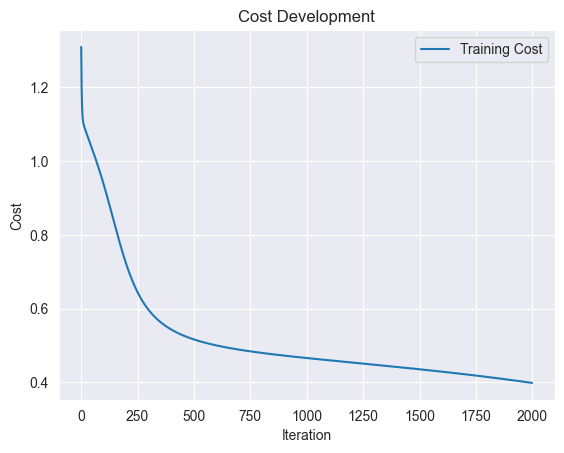

In [202]:
# Kostenentwicklung plotten
plt.plot(range(len(costs)), costs, label='Training Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Development')
plt.legend()
plt.show()

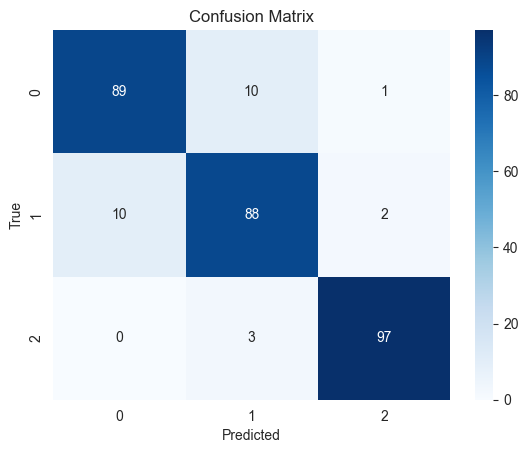

Overall Accuracy on Dev Set: 0.9133333333333333


In [203]:
from sklearn.metrics import confusion_matrix
y_pred_dev = mlperc.predict(Xdev_scaled)
conf_mat = confusion_matrix(np.argmax(ydev_scaled, axis=1), y_pred_dev)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy_dev = np.mean(y_pred_dev == np.argmax(ydev_scaled, axis=1))
print(f"Overall Accuracy on Dev Set: {accuracy_dev}")

  0%|          | 0/2000 [00:00<?, ?it/s]

MovieWriter imagemagick unavailable; using Pillow instead.


Number of saved epoch weights: 2000


KeyboardInterrupt: 

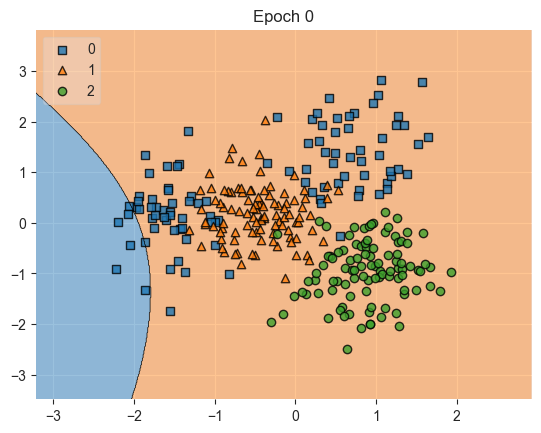

In [208]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.animation as animation

# Erzeuge und trainiere das Netzwerk (Beispiel)
mlperc = MLPClassifier(num_nodes_per_layer=[2, 20, 20, 3], lr=0.1, alpha=0.1, batch_size=32, max_num_steps=2000)
costs = mlperc.fit(Xdev_scaled, ydev_scaled.astype(np.int_))  # Kostenliste speichern

# Überprüfen Sie die Anzahl der gespeicherten Gewichte
print(f"Number of saved epoch weights: {len(mlperc.epoch_weights)}")

# Erstellen der Animation
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    mlperc.weights_ = mlperc.epoch_weights[frame]  # Zugriff auf die Gewichte zu einem bestimmten Zeitpunkt
    ydev_labels = np.argmax(ydev_scaled, axis=1)
    plot_decision_regions(Xdev_scaled, ydev_labels, clf=mlperc, ax=ax, legend=2)


    ax.set_title(f'Epoch {frame}')

ani = animation.FuncAnimation(fig, update, frames=range(0, len(mlperc.epoch_weights), 1), repeat=True)
ani.save('decision_regions.gif', writer='imagemagick', fps=5)

Unfortunately, the animation does not work properly; it could not finish loading.
Overall, the model seems to deliver a good result on the test dataset with high accuracy, which is also confirmed by the confusion matrix.

## 7. MLP-Implementierung for prediction

In this task, you will use your MLP implementation to develop a model for predicting blood cell types.
To do this, you should prepare the data so that it can be used for modeling. Additionally, you will develop various MLP variants and select the best one in terms of the F1 score using an appropriate method.

Further, calculate the unweighted average F1 score and plot the confusion matrix, both on the test set. Explain your approach and discuss the results.


In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
from typing import List, Union, Tuple, Iterable
from itertools import islice

In [132]:
bc_train = bc_train.drop("image filename", axis =1)
bc_test = bc_test.drop("image filename", axis =1)

(5087,)
(5088,)
[0 1 2 3 4]
[0 1 2 3 4]
(5087, 19)
(5088, 19)


  0%|          | 0/2000 [00:00<?, ?it/s]

Besten Parameter: {'alpha': 0.01, 'batch_size': 32, 'lr': 0.01, 'max_num_steps': 2000, 'num_nodes_per_layer': [19, 50, 20, 10, 5], 'random_seed': 42}
F1-Score: 0.8181580010071821
Accuracy: 0.9109669811320755
Confusion Matrix:
 [[ 102    0    1    0    3]
 [   3  252   37   14   66]
 [   4    3 1145   34   28]
 [   1    3  121  123   32]
 [   3   19   73    8 3013]]
['Neutrophil' 'Lymphocyte' 'Eosinophil' 'Monocyte' 'Basophil']


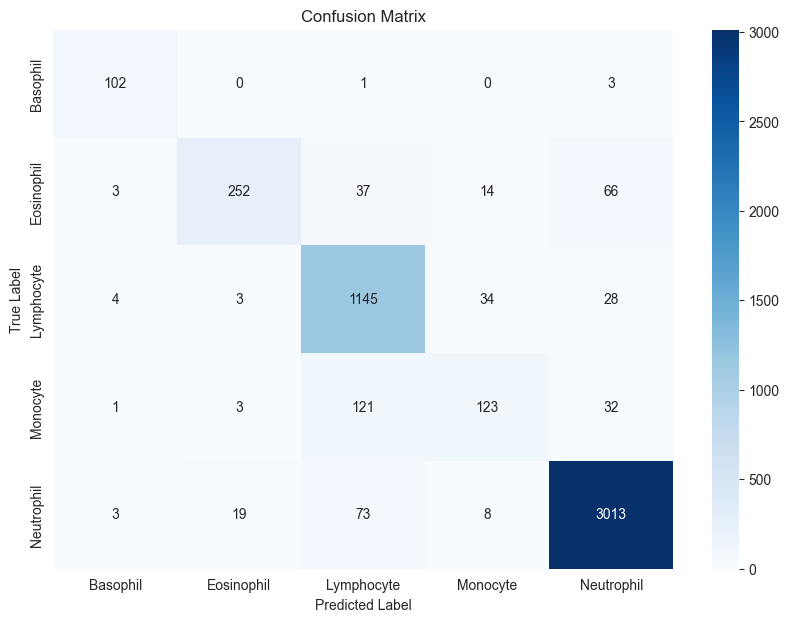

In [210]:
# Training und Testdaten
X_train = bc_train.drop(columns=['Class'])  # Features
y_train = bc_train['Class']                 # Labels
X_test = bc_test.drop(columns=['Class'])    # Features
y_test = bc_test['Class']                   # Labels

# Label encoden
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(y_train_encoded.shape)
print(y_test_encoded.shape)
print(np.unique(y_train_encoded))
print(np.unique(y_test_encoded))
print(X_train.shape)
print(X_test.shape)

# Merkmale skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definition verschiedener MLP-Versionen
architectures = [
    [X_train_scaled.shape[1], 20, 10, 5],
    [X_train_scaled.shape[1], 30, 15, 5],
    [X_train_scaled.shape[1], 50, 20, 10, 5]
]

# Verwendung von Grid Search, um die beste MLP-Variante zu finden
param_grid = {
    'num_nodes_per_layer': architectures,
    'lr': [0.01, 0.001],
    'alpha': [0.01, 0.001],
    'batch_size': [32, 64, 96],
    'max_num_steps': [2000],
    'random_seed': [42]
}

# Grid Search
mlp = MLPClassifier(num_nodes_per_layer=[X_train_scaled.shape[1], 10, 5])
grid_search = GridSearchCV(mlp, param_grid, scoring="f1_macro", cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_encoded)

# Auswertung des besten Modells
best_model = grid_search.best_estimator_
print("Besten Parameter:", grid_search.best_params_)

# Umwandlung der Labels in Zahlen
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Bewertung des besten Modells auf dem Testset
f1 = f1_score(y_test_encoded, y_pred, average='macro')
accuracy = accuracy_score(y_test_encoded, y_pred)
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

class_names = bc_train['Class'].unique()
print(class_names)

# Umwandlung der Zahlen wieder in Zeichenfolgen
labels = label_encoder.inverse_transform(np.arange(len(class_names)))

# Umwandlung der Confusion Matrix in ein DataFrame mit ganzzahligen Labels
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Zeichnen der Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Using GridSearch, the best possible parameters were identified:
{'alpha': 0.01, 'batch_size': 32, 'lr': 0.01, 'max_num_steps': 2000, 'num_nodes_per_layer': [19, 50, 20, 10, 5], 'random_seed': 42}
This configuration delivers the following acceptable metrics, indicating good performance:

* F1-Score: 0.8181580010071821
* Accuracy: 0.9109669811320755
However, it is evident that predicting the rare classes has significantly more errors compared to the dominant class, Neutrophil.


## 8. Batchsizes (not done yet)
64, 32, 16, 8, 4, 2, 1. Plot the development of the cost function for the training and test data over the number of iterations for each batch size. Measure the runtimes to achieve a similar loss in each case. What do you notice? What criteria would you use to optimally choose the batch sizes?

In [0]:
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [183]:
# Training und Testdaten
X_train = bc_train.drop(columns=['Class', 'image filename'])  # Features
y_train = bc_train['Class']                 # Labels
X_test = bc_test.drop(columns=['Class', 'image filename'])    # Features
y_test = bc_test['Class']

KeyError: "['image filename'] not found in axis"

In [211]:
"""
# Erstelle ein LabelEncoder-Objekt
label_encoder = LabelEncoder()
# Fitte den Encoder auf die Trainingsdaten und transformiere sie
y_train_encoded = label_encoder.fit_transform(y_train)
# Transformiere die Testdaten mit demselben Encoder
y_test_encoded = label_encoder.transform(y_test)

# One-Hot-Encoding vorbereiten
one_hot_encoder = OneHotEncoder()
y_train_one = one_hot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_one = one_hot_encoder.transform(y_test_encoded.reshape(-1, 1))

# Skalierung der Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

In [228]:
"""
batch_size = [265, 128, 64, 32, 16, 8, 4, 2, 1]

# Ergebnisse speichern
train_losses = {}
test_losses = {}
times = {}

# Training mit verschiedenen Batchgrößen
for batch_size in batch_sizes:
    print(f"Training mit Batchgröße {batch_size} ...")
    if isinstance(batch_size, list):
        batch_size = max(1, batch_size[0])
    else:
        batch_size = max(1, batch_size) 

    mlp2 = MLPClassifier(num_nodes_per_layer=[19, 30, 15, 5],
                         lr=0.01,
                         alpha=0.001,
                         batch_size=batch_size,
                         max_num_steps=2000,
                         random_seed=123)

"""

Training mit Batchgröße 265 ...
Training mit Batchgröße 128 ...
Training mit Batchgröße 64 ...
Training mit Batchgröße 32 ...
Training mit Batchgröße 16 ...
Training mit Batchgröße 8 ...
Training mit Batchgröße 4 ...
Training mit Batchgröße 2 ...
Training mit Batchgröße 1 ...


## 9. Additional Classification Algorithms

Now compare at least three other suitable classification methods. You are free to use any scikit-learn models to predict the blood cell types, aiming to achieve the best possible prediction in terms of the target metric, the F1-score. Optimize the respective hyperparameters for each method.

Additionally, calculate the unweighted average F1-score and plot the confusion matrix for each method.

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix

# Training und Testdaten
#X_train = bc_train.drop(columns=['Class', 'image filename'])  # Features
#y_train = bc_train['Class']                 # Labels
#X_test = bc_test.drop(columns=['Class', 'image filename'])    # Features
#y_test = bc_test['Class']

# Initialisieren der Modelle
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}

# Trainieren und Evaluieren der Modelle
for name, model in models.items():
    print(f"Training und Evaluierung von {name}...")
    model.fit(X_train_scaled, y_train_encoded)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test_encoded, y_pred, average='macro')
    print(f"F1-Score für {name}: {f1}")

    # Berechnung der Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    print(f"Confusion Matrix für {name}:\n{cm}")


Training und Evaluierung von Logistic Regression...
F1-Score für Logistic Regression: 0.8081940352887813
Confusion Matrix für Logistic Regression:
[[ 101    0    0    1    4]
 [   2  258   27   22   63]
 [   6   13 1126   38   31]
 [   0   15  120  123   22]
 [   3   25   76   11 3001]]
Training und Evaluierung von Random Forest...
F1-Score für Random Forest: 0.8201163593337892
Confusion Matrix für Random Forest:
[[ 101    0    1    0    4]
 [   4  268   31   10   59]
 [   6    0 1131   48   29]
 [   1    3  104  130   42]
 [   1   32   94    6 2983]]
Training und Evaluierung von Support Vector Machine...
F1-Score für Support Vector Machine: 0.8181580010071821
Confusion Matrix für Support Vector Machine:
[[ 102    0    1    0    3]
 [   3  252   37   14   66]
 [   4    3 1145   34   28]
 [   1    3  121  123   32]
 [   3   19   73    8 3013]]


## 10. Overview of Results

Summarize the results of the various models from the previous tasks for predicting blood cell types, including the dummy classifiers, in a table and also present them graphically.

Discuss your insights.

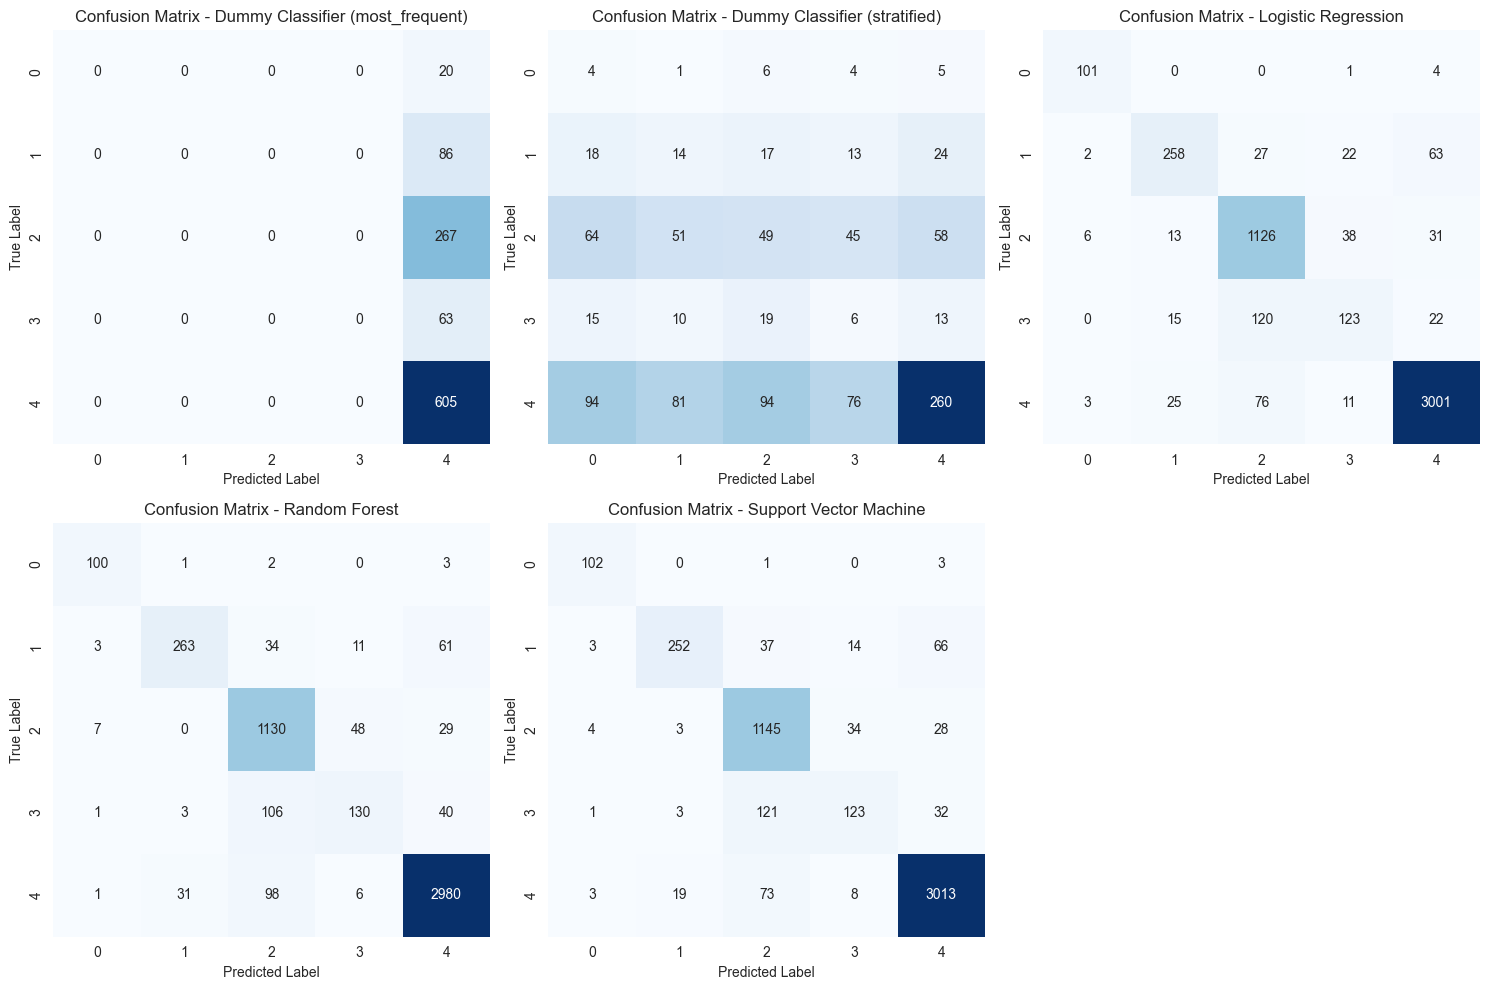

Ergebnisse der verschiedenen Modelle:
                                  F1-Score  \
Dummy Classifier (most_frequent)  0.365000   
Dummy Classifier (stratified)     0.197000   
Logistic Regression               0.808194   
Random Forest                     0.816260   
Support Vector Machine            0.818158   

                                                                   Confusion Matrix  
Dummy Classifier (most_frequent)  [[0, 0, 0, 0, 20], [0, 0, 0, 0, 86], [0, 0, 0,...  
Dummy Classifier (stratified)     [[4, 1, 6, 4, 5], [18, 14, 17, 13, 24], [64, 5...  
Logistic Regression               [[101, 0, 0, 1, 4], [2, 258, 27, 22, 63], [6, ...  
Random Forest                     [[100, 1, 2, 0, 3], [3, 263, 34, 11, 61], [7, ...  
Support Vector Machine            [[102, 0, 1, 0, 3], [3, 252, 37, 14, 66], [4, ...  


In [189]:
# Ergebnisse der verschiedenen Modelle
results = {
    "Dummy Classifier (most_frequent)": {
        "F1-Score": 0.365,
        "Confusion Matrix": [[0, 0, 0, 0, 20],
                             [0, 0, 0, 0, 86],
                             [0, 0, 0, 0, 267],
                             [0, 0, 0, 0, 63],
                             [0, 0, 0, 0, 605]]
    },
    "Dummy Classifier (stratified)": {
        "F1-Score": 0.197,
        "Confusion Matrix": [[ 4,  1,  6,  4, 5],
                             [18, 14, 17, 13, 24],
                             [64, 51, 49, 45, 58],
                             [15, 10, 19,  6, 13],
                             [94, 81, 94, 76, 260]]
    },
    "Logistic Regression": {
        "F1-Score": 0.8081940352887813,
        "Confusion Matrix": [[ 101,    0,    0,    1,    4],
                             [   2,  258,   27,   22,   63],
                             [   6,   13, 1126,   38,   31],
                             [   0,   15,  120,  123,   22],
                             [   3,   25,   76,   11, 3001]]
    },
    "Random Forest": {
        "F1-Score": 0.8162604283464605,
        "Confusion Matrix": [[ 100,    1,    2,    0,    3],
                             [   3,  263,   34,   11,   61],
                             [   7,    0, 1130,   48,   29],
                             [   1,    3,  106,  130,   40],
                             [   1,   31,   98,    6, 2980]]
    },
    "Support Vector Machine": {
        "F1-Score": 0.8181580010071821,
        "Confusion Matrix": [[ 102,    0,    1,    0,    3],
                             [   3,  252,   37,   14,   66],
                             [   4,    3, 1145,   34,   28],
                             [   1,    3,  121,  123,   32],
                             [   3,   19,   73,    8, 3013]]
    }
}

# Erstellen der Ergebnis-Tabelle
results_df = pd.DataFrame.from_dict(results, orient='index')

# Plot Confusion Matrix für jedes Modell
plt.figure(figsize=(15, 10))
for idx, (name, data) in enumerate(results.items(), start=1):
    plt.subplot(2, 3, idx)
    sns.heatmap(data["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Anzeigen der Ergebnis-Tabelle
print("Ergebnisse der verschiedenen Modelle:")
print(results_df)